In [5]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

# Text Pre-processing libraries
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Tensorflow imports to build the model.
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd
filepath="/content/twitter_data.csv"
try:
    df = pd.read_csv(filepath, on_bad_lines='warn')  # Use on_bad_lines instead
    print(df.head())
except pd.errors.ParserError as e:
    print(f"An error occurred while parsing the file: {e}")

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  


In [8]:
# dataset shape to know how many tweets in the datasets
print(f"num of tweets: {df.shape}")

# extract the text and labels
tweet = list(df['tweet'])
labels = list(df['class'])

num of tweets: (24783, 7)


In [9]:
import nltk
nltk.download('stopwords')
import re
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
# add rt to remove retweet in dataset (noise)
stop_words.add("rt")

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# change the user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)

    return text

# remove urls
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text

# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')

    return text


# remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)

    return text

## this function in to clean all the dataset by utilizing all the function above
def preprocess(datas):
    clean = []
    # change the @xxx into "user"
    clean = [change_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [10]:
import nltk
nltk.download('punkt')  # Download the 'punkt' resource
nltk.download('stopwords')
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
filepath="/content/twitter_data.csv"
df = pd.read_csv(filepath, on_bad_lines='warn')
tweet = list(df['tweet'])
# call the cleaning function
clean_tweet = preprocess(tweet)

In [11]:
import nltk
nltk.download('punkt')  # Download the 'punkt' resource
nltk.download('stopwords')
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
filepath="/content/twitter_data.csv"
df = pd.read_csv(filepath, on_bad_lines='warn')
tweet = list(df['tweet'])
labels = list(df['class']) # Define the 'labels' variable here
# call the cleaning function
clean_tweet = preprocess(tweet)

from sklearn.model_selection import train_test_split
# import the function
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, labels, test_size=0.2, random_state=42) # Now 'labels' is defined

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer # Import the Tokenizer cla
## Tokenizing -> basically we use tokenisation for many things, its commonly used for feature extraction in preprocessing. btw idk how it works as feature extraction tho :(
# declare the tokenizer
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Import the pad_sequences function
## Padding -> to uniform the datas
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

In [14]:
from tensorflow.keras.utils import to_categorical
# Import the to_categorical function# create hot_labels (idk whty tapi ini penting, kalo ga bakal error)
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

In [15]:
# another look on the number of tweet in test and training data

print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 4957
num train tweet: 19826


In [16]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
output_dim = 200

# LSTM model architechture (CNN + LSTM)
model = Sequential([
    # embedding layer is like idk
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 3 class (0, 1, 2)
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 26, 200)           3734200   
                                                                 
 lstm (LSTM)                 (None, 64)                67840     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3810747 (14.54 MB)
Trainable params: 38107

In [24]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
310/310 [==============================] - 53s 152ms/step - loss: 0.4626 - accuracy: 0.8419 - f1: 0.8171 - precision: 0.8513 - recall: 0.7925 - val_loss: 0.3313 - val_accuracy: 0.8864 - val_f1: 0.8868 - val_precision: 0.8969 - val_recall: 0.8771
Epoch 2/10
310/310 [==============================] - 49s 158ms/step - loss: 0.2350 - accuracy: 0.9188 - f1: 0.9188 - precision: 0.9289 - recall: 0.9091 - val_loss: 0.3221 - val_accuracy: 0.8886 - val_f1: 0.8893 - val_precision: 0.8959 - val_recall: 0.8829
Epoch 3/10
310/310 [==============================] - 47s 151ms/step - loss: 0.1470 - accuracy: 0.9480 - f1: 0.9482 - precision: 0.9511 - recall: 0.9453 - val_loss: 0.3756 - val_accuracy: 0.8820 - val_f1: 0.8826 - val_precision: 0.8868 - val_recall: 0.8785
Epoch 4/10
310/310 [==============================] - 48s 156ms/step - loss: 0.1006 - accuracy: 0.9646 - f1: 0.9645 - precision: 0.9659 - recall: 0.9631 - val_loss: 0.4992 - val_accuracy: 0.8687 - val_f1: 0.8701 - val_precision: 

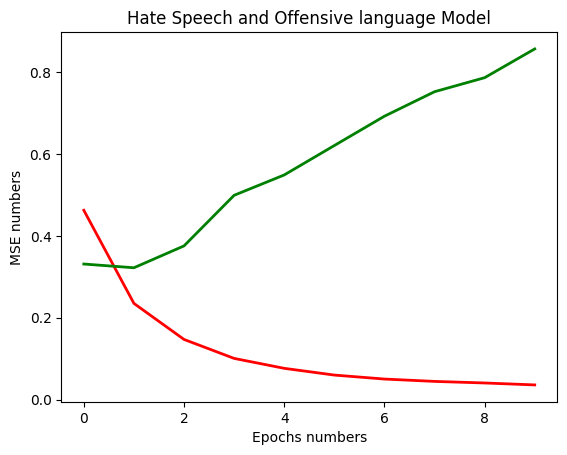

In [25]:
import matplotlib.pyplot as plt
hist = model.history.history
plt.plot(hist['loss'],'r',linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()